In [14]:

import pandas as pd
import datetime
import matplotlib.pyplot as plt
import glob
import os
import metpy
import numpy as np
from datetime import datetime
import xarray as xr
import metpy.calc as mpcalc
from metpy.units import units
from metpy.calc import dewpoint_from_relative_humidity
from metpy.calc import specific_humidity_from_dewpoint
from pint import UnitRegistry
ureg = UnitRegistry()
from windrose import WindroseAxes
import seaborn as sns
from matplotlib.patches import Patch
import re

In [15]:



def extract_epoch_from_header_bulletproof(file_path):
    """
    Extract epoch/timestamp from .nas file header robustly.
    Returns: (skip_rows, epoch_datetime_str) or (None, None) if not found
    """
    if not os.path.exists(file_path):
        print(f"  ✗ File does not exist: {file_path}")
        return None, None
    
    skip_rows = 0
    epoch_str = None
    
    try:
        # METHOD 1: Try with proper BOM handling
        with open(file_path, 'rb') as f:
            # Check for BOM
            bom = f.read(3)
            if bom == b'\xef\xbb\xbf':  # UTF-8 BOM
                print("  Detected UTF-8 BOM")
            else:
                f.seek(0)  # Rewind if no BOM
        
            # Read as binary first to avoid encoding issues
            binary_content = f.read(5000)  # Read first 5KB
        
        # Decode with error handling
        try:
            content = binary_content.decode('utf-8')
        except UnicodeDecodeError:
            content = binary_content.decode('latin-1', errors='ignore')
        
        # Clean BOM if present
        content = content.replace('\ufeff', '').replace('\uFEFF', '')
        
        # Split into lines
        lines = content.split('\n')
        
    except Exception as e:
        print(f"  ✗ Error reading file: {e}")
        # Fallback to simple read
        try:
            with open(file_path, 'r', encoding='utf-8-sig', errors='replace') as f:
                lines = []
                for i in range(100):  # Read first 100 lines
                    line = f.readline()
                    if not line:
                        break
                    lines.append(line)
        except Exception as e2:
            print(f"  ✗ Fallback read also failed: {e2}")
            return None, None
    
    print(f"  Scanning {len(lines)} header lines...")
    
    # PATTERNS TO LOOK FOR (case-insensitive)
    patterns = [
        # startdate: YYYYMMDDHHMMSS pattern
        (r'startdate:\s*(\d{8}\d{0,6})', 'startdate'),
        (r'start\s*date:\s*(\d{8}\d{0,6})', 'start date'),
        (r'epoch:\s*(\d{8}\d{0,6})', 'epoch'),
        (r'date:\s*(\d{8}\d{0,6})', 'date'),
        (r'time:\s*(\d{8}\d{0,6})', 'time'),
        (r'datetime:\s*(\d{8}\d{0,6})', 'datetime'),
        
        # YYYY-MM-DD HH:MM:SS patterns
        (r'startdate:\s*(\d{4}-\d{2}-\d{2}\s*\d{2}:\d{2}:\d{2})', 'startdate with dashes'),
        (r'epoch:\s*(\d{4}-\d{2}-\d{2}\s*\d{2}:\d{2}:\d{2})', 'epoch with dashes'),
        
        # Unix timestamp
        (r'startdate:\s*(\d{10})', 'unix timestamp'),
        (r'epoch:\s*(\d{10})', 'unix epoch'),
        
        # ISO format
        (r'startdate:\s*(\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2})', 'iso format'),
        
        # Generic date patterns anywhere in line
        (r'(\d{8}\d{6})\s', 'compact datetime (14 digits)'),
        (r'(\d{8}\d{4})\s', 'compact datetime (12 digits)'),
        (r'(\d{8})\s', 'compact date (8 digits)'),
        
        # Look for skiprows information
        (r'^\s*(\d+)\s*$', 'skiprow number'),
        (r'^(\d+)\s+', 'leading number'),
        (r'skip\s*rows?:\s*(\d+)', 'skip rows'),
        (r'header\s*lines?:\s*(\d+)', 'header lines'),
    ]
    
    # Also look for known header patterns
    header_keywords = [
        'header', 'metadata', 'comment', '#', 
        'startdate', 'epoch', 'date', 'time',
        'station', 'location', 'latitude', 'longitude',
        'created', 'generated', 'produced'
    ]
    
    skip_row_candidates = []
    epoch_candidates = []
    header_end_line = None
    
    for line_num, line in enumerate(lines):
        line = line.strip()
        if not line:  # Skip empty lines
            continue
        
        print(f"    Line {line_num}: {repr(line[:80])}")
        
        # Check if this looks like a skiprow number (just a number)
        if re.match(r'^\s*\d+\s*$', line):
            try:
                skip_value = int(line.strip())
                skip_row_candidates.append((line_num, skip_value))
                print(f"      Found skiprow candidate: {skip_value}")
            except:
                pass
        
        # Check for all patterns
        for pattern, pattern_name in patterns:
            match = re.search(pattern, line, re.IGNORECASE)
            if match:
                value = match.group(1)
                print(f"      Pattern '{pattern_name}' matched: {value}")
                
                if pattern_name in ['skiprow number', 'leading number', 'skip rows', 'header lines']:
                    try:
                        skip_row_candidates.append((line_num, int(value)))
                    except:
                        pass
                else:
                    # This might be an epoch/date value
                    epoch_candidates.append((line_num, value, pattern_name))
        
        # Check if line contains header keywords
        if any(keyword in line.lower() for keyword in header_keywords):
            print(f"      Contains header keyword")
            if header_end_line is None:
                header_end_line = line_num
        
        # Check if we've reached data (numbers separated by spaces/tabs)
        # This helps determine where header ends
        if re.match(r'^[\d\s\.\-+eE]+$', line.replace('\t', ' ')):
            print(f"      Looks like data (numbers only)")
            if header_end_line is None:
                header_end_line = line_num - 1
            break
    
    # DECISION LOGIC
    # Determine skip_rows
    if skip_row_candidates:
        # Use the first valid skiprow candidate (your original logic)
        skip_rows = skip_row_candidates[0][1] - 1 if skip_row_candidates[0][1] > 0 else 0
        print(f"  Selected skip_rows: {skip_rows} (from candidate {skip_row_candidates[0][1]})")
    elif header_end_line is not None:
        skip_rows = header_end_line + 1
        print(f"  Using header_end_line for skip_rows: {skip_rows}")
    else:
        # Default: skip first line if it's not numeric data
        if lines and not re.match(r'^[\d\s\.\-+]+$', lines[0].strip()):
            skip_rows = 1
            print(f"  Default skip_rows: {skip_rows}")
    
    # Determine epoch
    if epoch_candidates:
        # Try to parse each candidate
        for line_num, epoch_value, pattern_name in epoch_candidates:
            print(f"  Trying to parse epoch candidate: {epoch_value} ({pattern_name})")
            
            parsed_datetime = None
            
            try:
                # Handle different formats
                if re.match(r'^\d{14}$', epoch_value):  # YYYYMMDDHHMMSS
                    parsed_datetime = datetime.strptime(epoch_value, '%Y%m%d%H%M%S')
                    epoch_str = parsed_datetime.strftime('%Y-%m-%d %H:%M:%S')
                
                elif re.match(r'^\d{12}$', epoch_value):  # YYYYMMDDHHMM
                    parsed_datetime = datetime.strptime(epoch_value, '%Y%m%d%H%M')
                    epoch_str = parsed_datetime.strftime('%Y-%m-%d %H:%M:00')
                
                elif re.match(r'^\d{8}$', epoch_value):  # YYYYMMDD
                    parsed_datetime = datetime.strptime(epoch_value, '%Y%m%d')
                    epoch_str = parsed_datetime.strftime('%Y-%m-%d 00:00:00')
                
                elif re.match(r'^\d{4}-\d{2}-\d{2}\s\d{2}:\d{2}:\d{2}$', epoch_value):
                    parsed_datetime = datetime.strptime(epoch_value, '%Y-%m-%d %H:%M:%S')
                    epoch_str = epoch_value
                
                elif re.match(r'^\d{10}$', epoch_value):  # Unix timestamp
                    parsed_datetime = datetime.fromtimestamp(int(epoch_value))
                    epoch_str = parsed_datetime.strftime('%Y-%m-%d %H:%M:%S')
                
                elif re.match(r'^\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2}$', epoch_value):
                    parsed_datetime = datetime.fromisoformat(epoch_value.replace('Z', '+00:00'))
                    epoch_str = parsed_datetime.strftime('%Y-%m-%d %H:%M:%S')
                
                if parsed_datetime:
                    print(f"  ✓ Successfully parsed epoch: {epoch_str}")
                    return skip_rows, epoch_str
                    
            except Exception as e:
                print(f"    ✗ Failed to parse {epoch_value}: {e}")
                continue
    
    # If no epoch found, check filename for date pattern
    filename = os.path.basename(file_path)
    print(f"  Checking filename for date pattern: {filename}")
    
    # Common patterns in filenames
    filename_patterns = [
        r'(\d{8})',  # YYYYMMDD
        r'(\d{12})',  # YYYYMMDDHHMM
        r'(\d{14})',  # YYYYMMDDHHMMSS
        r'(\d{4})(\d{2})(\d{2})',  # YYYY MM DD
    ]
    
    for pattern in filename_patterns:
        match = re.search(pattern, filename)
        if match:
            date_str = match.group(1)
            try:
                if len(date_str) == 14:
                    parsed = datetime.strptime(date_str, '%Y%m%d%H%M%S')
                    epoch_str = parsed.strftime('%Y-%m-%d %H:%M:%S')
                elif len(date_str) == 12:
                    parsed = datetime.strptime(date_str, '%Y%m%d%H%M')
                    epoch_str = parsed.strftime('%Y-%m-%d %H:%M:00')
                elif len(date_str) == 8:
                    parsed = datetime.strptime(date_str, '%Y%m%d')
                    epoch_str = parsed.strftime('%Y-%m-%d 00:00:00')
                
                if epoch_str:
                    print(f"  ✓ Extracted epoch from filename: {epoch_str}")
                    return skip_rows, epoch_str
            except:
                continue
    
    print(f"  ✗ No epoch found in file header or filename")
    return skip_rows, None  # Return skip_rows even if no epoch found

#

In [16]:
# READ nas file
# Function to extract epoch from the first few rows of the CSV file
# def extract_epoch_from_header(file):
#     # Read the first few lines to find the epoch (assuming it's in a comment or a header)
#     with open(file, 'r') as f:
#         skiprow = f.readline()
#         skiprow = skiprow.strip().split()[0]
#         for line in f:
#             if "startdate:" in line.lower():  # Assuming the word 'epoch' is present in the line
#                 # Extract the epoch date (this assumes the date is the second item in the line)
#                 epoch = line.strip().split()[1]
#                 return int(skiprow)-1, epoch[0:4]+"-"+epoch[4:6]+"-"+epoch[6:8]+" "+epoch[8:10]+":"+epoch[10:12]+":"+epoch[12:14]
#     return None  # Return None if no epoch is found
# Your original code with the bulletproof function

# Function to load and adjust time for each CSV
def load_and_adjust_time(file):
    # Try to extract the epoch from the header or a specific column
    #nskiprows,epoch = extract_epoch_from_header(file)
    nskiprows, epoch = extract_epoch_from_header_bulletproof(file)
   
    if epoch is None:
        raise ValueError(f"Could not find epoch for file: {file}")
   
    # Load the actual data (skipping header if necessary)
    df = pd.read_csv(file, skiprows=nskiprows,sep="\s+")  # Adjust skiprows based on where the data starts
   
    # Convert 'time' column to a datetime, assuming it's in days
    # Adjust time column to start from the epoch time found in the file
    df['starttime_dt'] = pd.to_timedelta(df['start_time'], unit='D') + pd.Timestamp(epoch)
    df = df[df.numflag_wind_speed != 0.999]
    #df.index = df["starttime_dt"]
    #data["starttime_dt"] = pd.to_datetime(data["starttime"],unit='D',origin=pd.Timestamp('2015-01-01 00:41:00'))
   
    # Return the adjusted DataFrame
    return df

<>:26: SyntaxWarning: invalid escape sequence '\s'
<>:26: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_3837513/3164685674.py:26: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(file, skiprows=nskiprows,sep="\s+")  # Adjust skiprows based on where the data starts


In [17]:
# Set working directory (fixed the path - removed the ValueError)
working_dir = '../data_meteo/'

# Find all CSV files (using .nas extension as in your code)
meteo_files = glob.glob(working_dir + "*.nas")
print(f"Found {len(meteo_files)} files:")
for file in meteo_files:
    print(file)
# this function reads and adjust times for all CSV files
dfs = []
for file in meteo_files:
    df = load_and_adjust_time(file)
    dfs.append(df)

# concatenates all DataFrames (based on time)
meteoCG_df = pd.concat(dfs).sort_values('starttime_dt').reset_index(drop=True)

# Show combined DataFrame
#print(meteoCG_df)


Found 5 files:
../data_meteo/IT0014R.20240101000000.20250214101300.aws..met.1y.1mn...lev0.nas
../data_meteo/IT0014R.20150101000000.20160722000000.aws..met.1y.1h...lev2.nas
../data_meteo/IT0014R.20180101000000.20191111101200.aws..met.1y.1h...lev2.nas
../data_meteo/IT0014R.20160101000000.20170620000000.aws..met.1y.1h...lev2.nas
../data_meteo/IT0014R.20170101000000.20180404104400.aws..met.1y.1h...lev2.nas
  Scanning 72 header lines...
    Line 0: '68 1001'
      Pattern 'leading number' matched: 68
      Looks like data (numbers only)
  Selected skip_rows: 67 (from candidate 68)
  Checking filename for date pattern: IT0014R.20240101000000.20250214101300.aws..met.1y.1mn...lev0.nas
  ✓ Extracted epoch from filename: 2024-01-01 00:00:00
  Detected UTF-8 BOM
  Scanning 85 header lines...
    Line 0: '69 1001'
      Pattern 'leading number' matched: 69
      Looks like data (numbers only)
  Selected skip_rows: 68 (from candidate 69)
  Checking filename for date pattern: IT0014R.20150101000000.

In [18]:

meteoCG_df.set_index('starttime_dt', inplace=True)
# Check if there format hh:mm:ss is in the index
formatted_df_CG = meteoCG_df.copy()
formatted_df_CG.index = meteoCG_df.index.strftime('%Y-%m-%d %H:%M:%S')
print(formatted_df_CG.head())

                     start_time  end_time  wind_speed  numflag_wind_speed  \
starttime_dt                                                                
2015-01-01 00:00:00    0.000000  0.041667         2.1                 0.0   
2015-01-01 01:00:00    0.041667  0.083333         2.0                 0.0   
2015-01-01 01:59:59    0.083333  0.125000         2.3                 0.0   
2015-01-01 03:00:00    0.125000  0.166667         2.9                 0.0   
2015-01-01 04:00:00    0.166667  0.208333         3.2                 0.0   

                     wind_direction  numflag_wind_direction  temperature  \
starttime_dt                                                               
2015-01-01 00:00:00           356.6                     0.0        273.6   
2015-01-01 01:00:00           354.9                     0.0        274.2   
2015-01-01 01:59:59           359.9                     0.0        275.0   
2015-01-01 03:00:00           339.6                     0.0        276.1   
2015

In [19]:
''
formatted_df_CG.drop(columns=['start_time','end_time', 'relative_humidity', 'numflag_relative_humidity', 'pressure', 'numflag_pressure', 'global_radiation', 'numflag_global_radiation',
                               'solar_radiation','numflag_solar_radiation','precipitation_amount',  'numflag_precipitation_amount', 'temperature', 'numflag_temperature' ], inplace=True)
# Option 1: Using set_index()

formatted_df_CG.head()

,wind_speed,numflag_wind_speed,wind_direction,numflag_wind_direction
starttime_dt,,,,
2015-01-01 00:00:00,2.1,0.0,356.6,0.0
2015-01-01 01:00:00,2.0,0.0,354.9,0.0
2015-01-01 01:59:59,2.3,0.0,359.9,0.0
2015-01-01 03:00:00,2.9,0.0,339.6,0.0
2015-01-01 04:00:00,3.2,0.0,327.6,0.0


In [20]:


# Drop rows where 'values' equals 9.999999999
filt_df_CG = formatted_df_CG[formatted_df_CG['wind_speed'] != 9.999999999]
filt_df_CG = formatted_df_CG[formatted_df_CG['wind_speed'] != 999.99]
filt_df_CG = formatted_df_CG[formatted_df_CG['wind_speed'] != 9999.999999]
filt_df_CG = formatted_df_CG[formatted_df_CG['wind_speed'] != 9999.99]
filt_df_CG = formatted_df_CG[formatted_df_CG['wind_speed'] != 99999.99]
filt_df_CG = formatted_df_CG[formatted_df_CG['wind_speed'] != 9999]
filt_df_CG = formatted_df_CG[formatted_df_CG['wind_speed'] != 99.99]
filt_df_CG = formatted_df_CG[formatted_df_CG['wind_speed'] != 9.999999999]
filt_df_CG = formatted_df_CG[formatted_df_CG['wind_speed'] != 999]
filt_df_CG = formatted_df_CG[formatted_df_CG['wind_speed'] != 9.999999999]
filt_df_CG = formatted_df_CG[formatted_df_CG['wind_speed'] != 99999.99]
filt_df_CG = formatted_df_CG[formatted_df_CG['wind_speed'] != 9.999999999]
filt_df_CG = formatted_df_CG[formatted_df_CG['wind_speed'] != 9999.99]
filt_df_CG = formatted_df_CG[formatted_df_CG['wind_speed'] != 9.999999999]

count = len(formatted_df_CG)
# Count remaining lines
remaining_count = len(filt_df_CG)

print("Filtered DataFrame:")
#print(filt_df_CG)
print(f"\nNumber of lines before dropping: {count}")
print(f"\nNumber of lines after dropping: {remaining_count}")


Filtered DataFrame:

Number of lines before dropping: 200172

Number of lines after dropping: 200172


In [21]:
filt_df_CG.drop(columns=['numflag_wind_speed','numflag_wind_direction' ], inplace=True)

In [22]:
# Assuming df_filtered is your DataFrame with datetime index 'starttime_dt'

# Define date range
start_date = '2016-01-01'
end_date = '2019-12-31'

# Create subset based on date range using loc (inclusive of both dates)
meteo_CG_16_19 = filt_df_CG.loc[start_date:end_date]


# Print information about the subset
print(f"Date range: {start_date} to {end_date}")
print(f"Original DataFrame shape: {filt_df_CG.shape}")
print(f"Subset DataFrame shape: {meteo_CG_16_19.shape}")
print(f"Number of rows in subset: {len(meteo_CG_16_19)}")

# Show first few rows of the subset
print("\nFirst 5 rows of subset:")
print(meteo_CG_16_19.head())

Date range: 2016-01-01 to 2019-12-31
Original DataFrame shape: (200172, 2)
Subset DataFrame shape: (17123, 2)
Number of rows in subset: 17123

First 5 rows of subset:
                     wind_speed  wind_direction
starttime_dt                                   
2016-01-01 00:00:00         2.3            30.3
2016-01-01 01:00:00         1.0             7.9
2016-01-01 01:59:59         1.9            33.2
2016-01-01 03:00:00         2.4            28.0
2016-01-01 04:00:00         2.4            37.0


In [23]:

# Apply condition: keep rows where ws_2m > 0.5
meteo_CG_16_19_filt =meteo_CG_16_19[meteo_CG_16_19['wind_speed'] > 0.5]



# Count lines before and after
original_count = len(meteo_CG_16_19)
filtered_count = len(meteo_CG_16_19_filt)

print("Original DataFrame:")
print(original_count)
print(f"\nOriginal count: {original_count}")

print("\nFiltered DataFrame (ws_2m > 0.5):")
print(meteo_CG_16_19_filt)
print(f"\nFiltered count: {filtered_count}")

Original DataFrame:
17123

Original count: 17123

Filtered DataFrame (ws_2m > 0.5):
                     wind_speed  wind_direction
starttime_dt                                   
2016-01-01 00:00:00         2.3            30.3
2016-01-01 01:00:00         1.0             7.9
2016-01-01 01:59:59         1.9            33.2
2016-01-01 03:00:00         2.4            28.0
2016-01-01 04:00:00         2.4            37.0
...                         ...             ...
2018-12-30 19:59:59         5.0           313.2
2018-12-30 21:00:00         4.4           320.0
2018-12-30 22:00:00         2.6           335.6
2018-12-30 22:59:59         2.9           336.8
2018-12-31 00:00:00         3.3           329.1

[17078 rows x 2 columns]

Filtered count: 17078


In [ ]:
plt.scatter(meteo_CG_16_19_filt.index, meteo_CG_16_19_filt['wind_speed'], marker='x', s=0.06, color='blue', label='Temperature')

In [24]:
#Prepare the Data and Calculate Wind Sectors
# Add wind direction sectors (8-point compass)
def direction_to_sector(direction):
    """Convert wind direction in degrees to 8-point compass sectors"""
    sectors = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']
    sector_bounds = [22.5, 67.5, 112.5, 157.5, 202.5, 247.5, 292.5, 337.5]
    
    for i, bound in enumerate(sector_bounds):
        if direction < bound:
            return sectors[i]
    return 'N'  # For directions between 337.5 and 360/0

In [26]:
# First, let's check what your dataframe looks like
print("=== DATAFRAME INFO ===")
print(f"Shape: {meteo_CG_16_19_filt.shape}")
print(f"\nColumns: {meteo_CG_16_19_filt.columns.tolist()}")
print(f"\nIndex type: {type(meteo_CG_16_19_filt.index)}")
print(f"Index name: {meteo_CG_16_19_filt.index.name}")


print("\n=== DATATYPES ===")
print(meteo_CG_16_19_filt.dtypes)

# SOLUTION 1: If 'starttime_dt' is a column (most common case)
if 'starttime_dt' in meteo_CG_16_19_filt.columns:
    print("\n=== SOLUTION 1: Using 'starttime_dt' column ===")
    
    # Convert to datetime if needed
    if not pd.api.types.is_datetime64_any_dtype(meteo_CG_16_19_filt['starttime_dt']):
        print("Converting 'starttime_dt' to datetime...")
        meteo_CG_16_19_filt['starttime_dt'] = pd.to_datetime(meteo_CG_16_19_filt['starttime_dt'])
    
    # Extract month from the COLUMN (using .dt.month)
    meteo_CG_16_19_filt['month'] = meteo_CG_16_19_filt['starttime_dt'].dt.month
    
    
    print("✓ Added month from column")
    print(meteo_CG_16_19_filt[['starttime_dt', 'wind_speed', 'wind_direction', 'month', 'month_name']].head())

# SOLUTION 2: If you want to use the index (and 'starttime_dt' is the index name)
elif meteo_CG_16_19_filt.index.name == 'starttime_dt':
    print("\n=== SOLUTION 2: Converting index to datetime ===")
    
    # Convert the index to datetime
    meteo_CG_16_19_filt.index = pd.to_datetime(meteo_CG_16_19_filt.index)
    
    # Now you can use .month on the index
    meteo_CG_16_19_filt['month'] = meteo_CG_16_19_filt.index.month
    
    
    print("✓ Added month from datetime index")
    print(meteo_CG_16_19_filt[['wind_speed', 'wind_direction', 'month']].head())

# SOLUTION 3: If the index contains datetime strings but isn't named
else:
    print("\n=== SOLUTION 3: Generic approach ===")
    
    # Try to convert index to datetime
    try:
        meteo_CG_16_19_filt.index = pd.to_datetime(meteo_CG_16_19_filt.index)
        meteo_CG_16_19_filt['month'] = meteo_CG_16_19_filt.index.month
        print("✓ Converted index to datetime and added month")
    except:
        print("✗ Could not convert index to datetime")
        
        # Last resort: check if any column looks like datetime
        for col in meteo_CG_16_19_filt.columns:
            if any(keyword in col.lower() for keyword in ['time', 'date', 'datetime']):
                print(f"Trying column: {col}")
                try:
                    meteo_CG_16_19_filt['month'] = pd.to_datetime(meteo_CG_16_19_filt[col]).dt.month
                    print(f"✓ Added month from column '{col}'")
                    break
                except:
                    continue

# Add season based on month
if 'month' in meteo_CG_16_19_filt.columns:
    print("\n=== ADDING SEASON ===")
    
    def get_season(month):
        if month in [12, 1, 2]:
            return 'Winter'
        elif month in [3, 4, 5]:
            return 'Spring'
        elif month in [6, 7, 8]:
            return 'Summer'
        else:
            return 'Autumn'
    
    meteo_CG_16_19_filt['season'] = meteo_CG_16_19_filt['month'].apply(get_season)
    
    print("✓ Added season column")
    print(f"\nSeason distribution:")
    print(meteo_CG_16_19_filt['season'].value_counts())
    
    print(f"\nMonth distribution:")
    

# Final check
print("\n=== FINAL DATAFRAME INFO ===")
print(f"Columns: {meteo_CG_16_19_filt.columns.tolist()}")
print(f"\nFirst few rows with new columns:")
cols_to_show = []
for col in ['starttime_dt', 'wind_speed', 'wind_direction', 'month',  'season']:
    if col in meteo_CG_16_19_filt.columns:
        cols_to_show.append(col)
print(meteo_CG_16_19_filt[cols_to_show].head())

=== DATAFRAME INFO ===
Shape: (17078, 3)

Columns: ['wind_speed', 'wind_direction', 'month']

Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index name: starttime_dt

=== DATATYPES ===
wind_speed        float64
wind_direction    float64
month               int32
dtype: object

=== SOLUTION 2: Converting index to datetime ===
✓ Added month from datetime index
                     wind_speed  wind_direction  month
starttime_dt                                          
2016-01-01 00:00:00         2.3            30.3      1
2016-01-01 01:00:00         1.0             7.9      1
2016-01-01 01:59:59         1.9            33.2      1
2016-01-01 03:00:00         2.4            28.0      1
2016-01-01 04:00:00         2.4            37.0      1

=== ADDING SEASON ===
✓ Added season column

Season distribution:
season
Winter    6279
Spring    5145
Autumn    2925
Summer    2729
Name: count, dtype: int64

Month distribution:

=== FINAL DATAFRAME INFO ===
Columns: ['wind_speed', 

/tmp/ipykernel_3837513/1651369777.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meteo_CG_16_19_filt['month'] = meteo_CG_16_19_filt.index.month
/tmp/ipykernel_3837513/1651369777.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meteo_CG_16_19_filt['season'] = meteo_CG_16_19_filt['month'].apply(get_season)


In [30]:
total_rows = len(meteo_CG_16_19_filt)
total_rows

17078

In [31]:
# Apply sector classification
meteo_CG_16_19_filt['Wind_Sector'] = meteo_CG_16_19_filt['wind_direction'].apply(direction_to_sector)

print("Wind Sector Distribution:")
print(meteo_CG_16_19_filt['Wind_Sector'].value_counts().sort_index())

Wind Sector Distribution:
Wind_Sector
E     1755
N     2568
NE    2562
NW    3691
S      969
SE    2465
SW     728
W     2340
Name: count, dtype: int64


/tmp/ipykernel_3837513/159629697.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meteo_CG_16_19_filt['Wind_Sector'] = meteo_CG_16_19_filt['wind_direction'].apply(direction_to_sector)


/tmp/ipykernel_3837513/3831988162.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Figure saved as 'wind_rose_CG_16_19.png' with 300 DPI


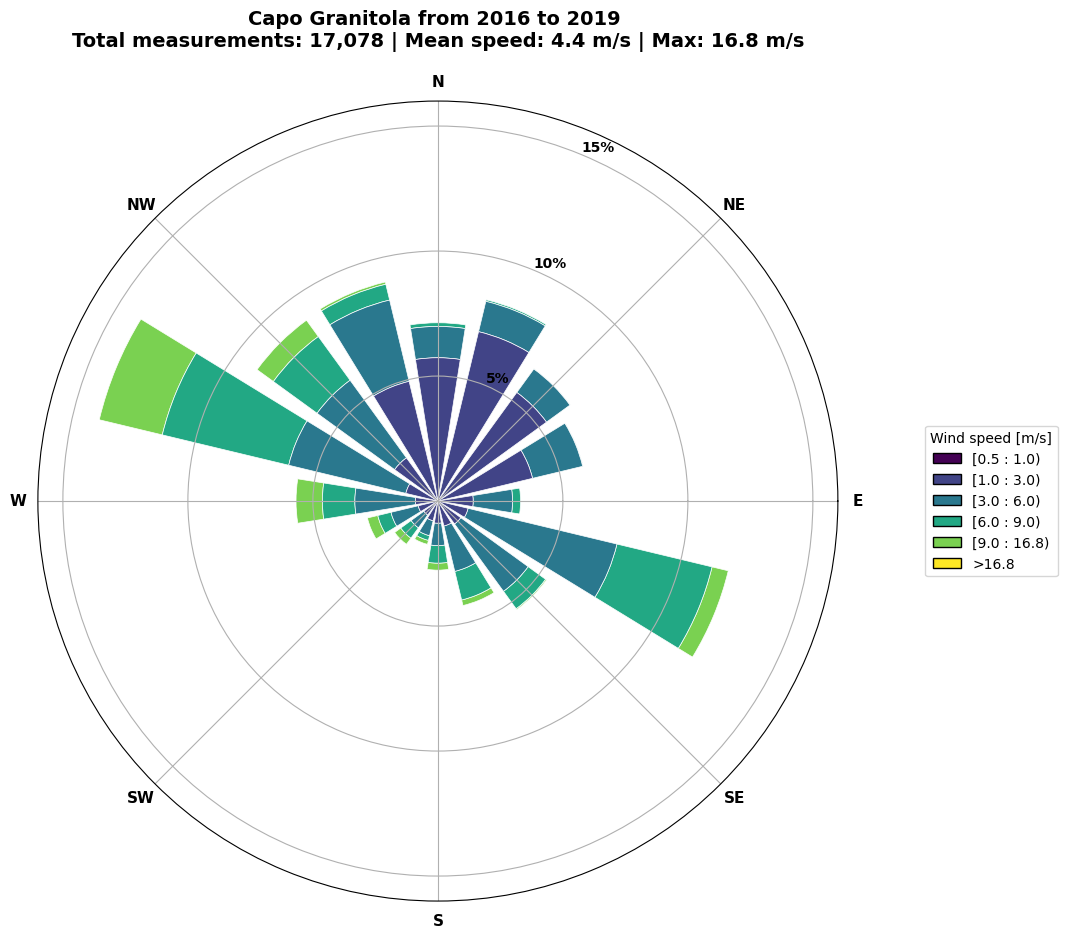

In [32]:
# Extract wind speed and direction
ws = meteo_CG_16_19_filt['wind_speed'].values
wd = meteo_CG_16_19_filt['wind_direction'].values

# Define custom wind speed bins (in m/s)
# Common categories 
speed_bins = [0.5, 1, 3, 6, 9, meteo_CG_16_19_filt['wind_speed'].max()]  #


# Create bin labels
bin_labels = [
    '0.5-1',     
    '1-3',       
    '3-6',       
    '6-9',       
    '9-{:.1f}'.format(meteo_CG_16_19_filt['wind_speed'].max())      
    ]

# Create wind rose
fig = plt.figure(figsize=(12, 10))
ax = WindroseAxes.from_ax(fig=fig)

# Plot with custom bins
bars = ax.bar(wd, ws, normed=True, opening=0.8, edgecolor='white', 
              linewidth=0.5, bins=speed_bins, cmap=plt.cm.viridis)

# Customize frequency circles (radial grid)
# Set specific frequency values to display
ax.set_yticks([5, 10, 15])  # Frequencies in percent
ax.set_yticklabels(['5%', '10%', '15%'], fontsize=10, fontweight='bold')

# Set radial limits
ax.set_ylim(0, 16)  # Show up to 30% frequency

# Customize directional labels
ax.set_xticklabels(['E', 'NE', 'N', 'NW', 'W', 'SW', 'S', 'SE'], 
                   fontsize=11, fontweight='bold')

# Customize legend with bin labels
legend = ax.legend(title='Wind speed [m/s]', loc='center left', 
                   bbox_to_anchor=(1.1, 0.5), labels=bin_labels)

# Add statistics
total_points = len(ws)
mean_speed = np.mean(ws)
max_speed = np.max(ws)

plt.title(f'Capo Granitola from 2016 to 2019 \nTotal measurements: {total_points:,} | Mean speed: {mean_speed:.1f} m/s | Max: {max_speed:.1f} m/s', 
          fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
#plt.show()
# Usage with all white backgrounds:
#fig = export_as_png_high_quality_all_white(filename='wind_rose_CG_16_19.png')

#SAVE THE FIGURE AS PNG WITH 300 DPI
output_filename = 'wind_rose_CG_16_19.png'
fig.savefig(output_filename, dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
print(f"Figure saved as '{output_filename}' with 300 DPI")

# Now show the figure (optional)
plt.show()

✓ Winter: 6279 data points
✓ Spring: 5145 data points
✓ Summer: 2729 data points
✓ Autumn: 2925 data points

Creating individual wind rose plots for each season...


/tmp/ipykernel_3837513/3055275175.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


✓ Winter wind rose saved as 'wind_rose_winter.png'


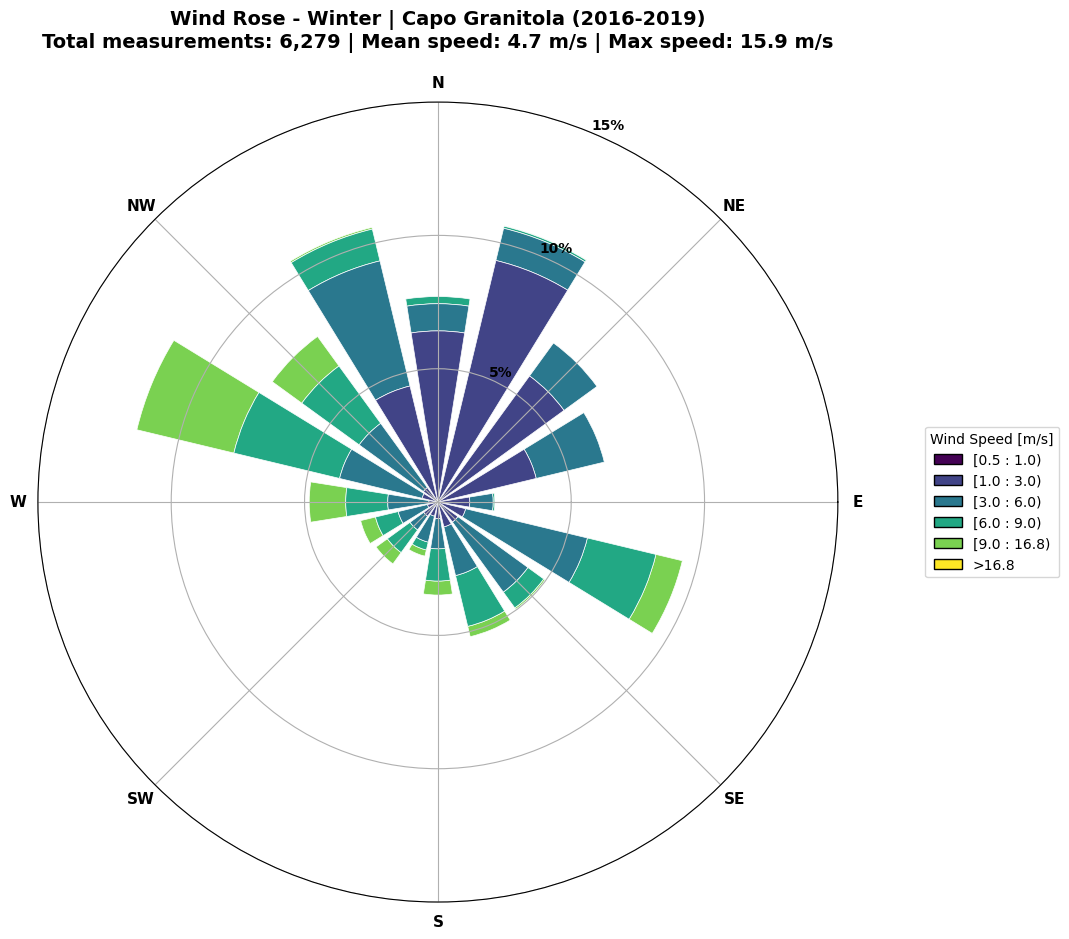

/tmp/ipykernel_3837513/3055275175.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


✓ Spring wind rose saved as 'wind_rose_spring.png'


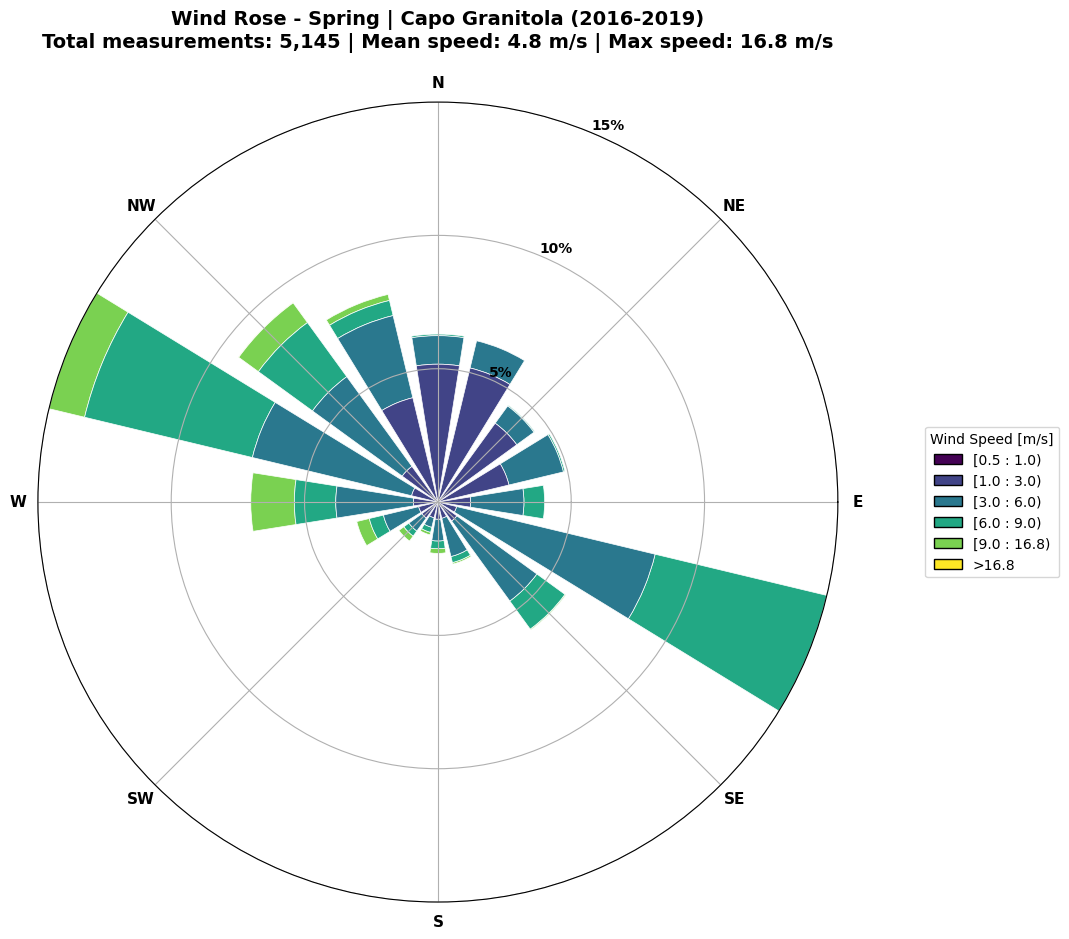

/tmp/ipykernel_3837513/3055275175.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


✓ Summer wind rose saved as 'wind_rose_summer.png'


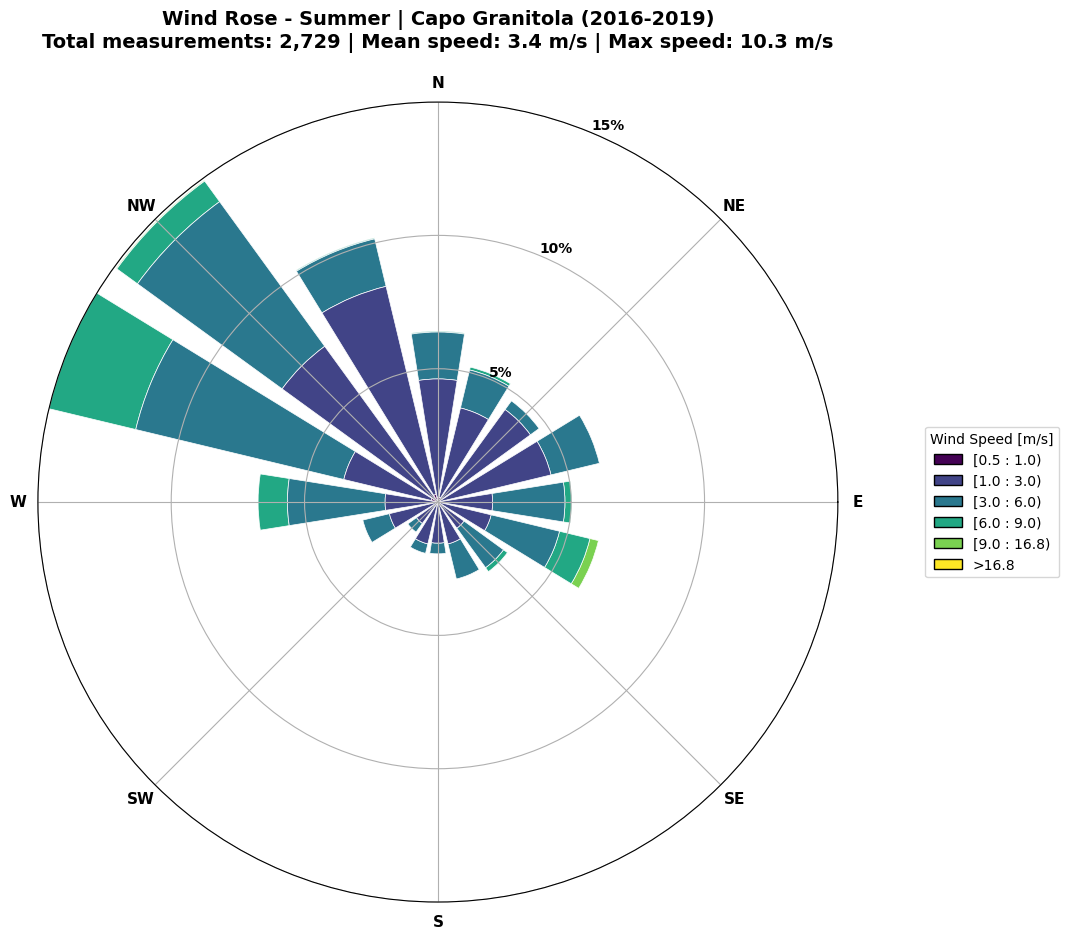

/tmp/ipykernel_3837513/3055275175.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


✓ Autumn wind rose saved as 'wind_rose_autumn.png'


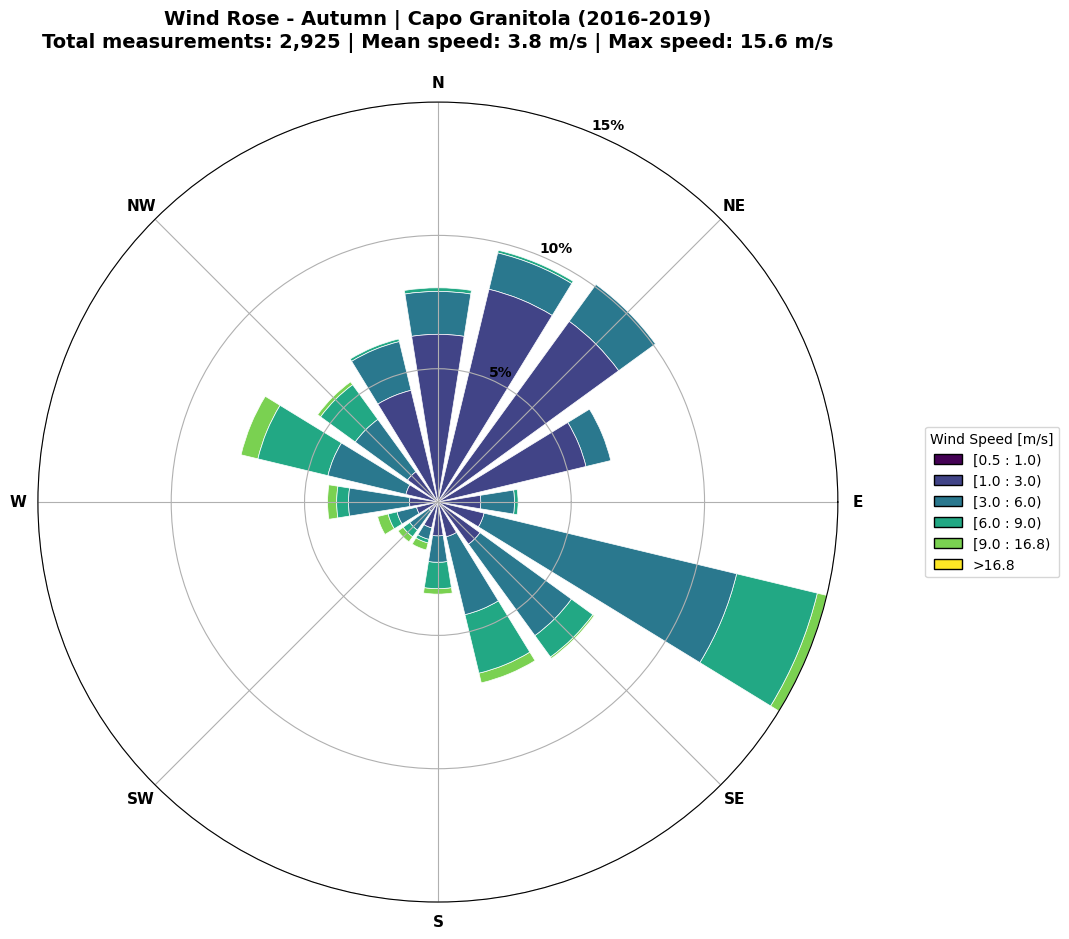


Creating combined plot for 4 seasons...
✓ Combined seasonal plot saved as 'wind_rose_seasons_combined.png'


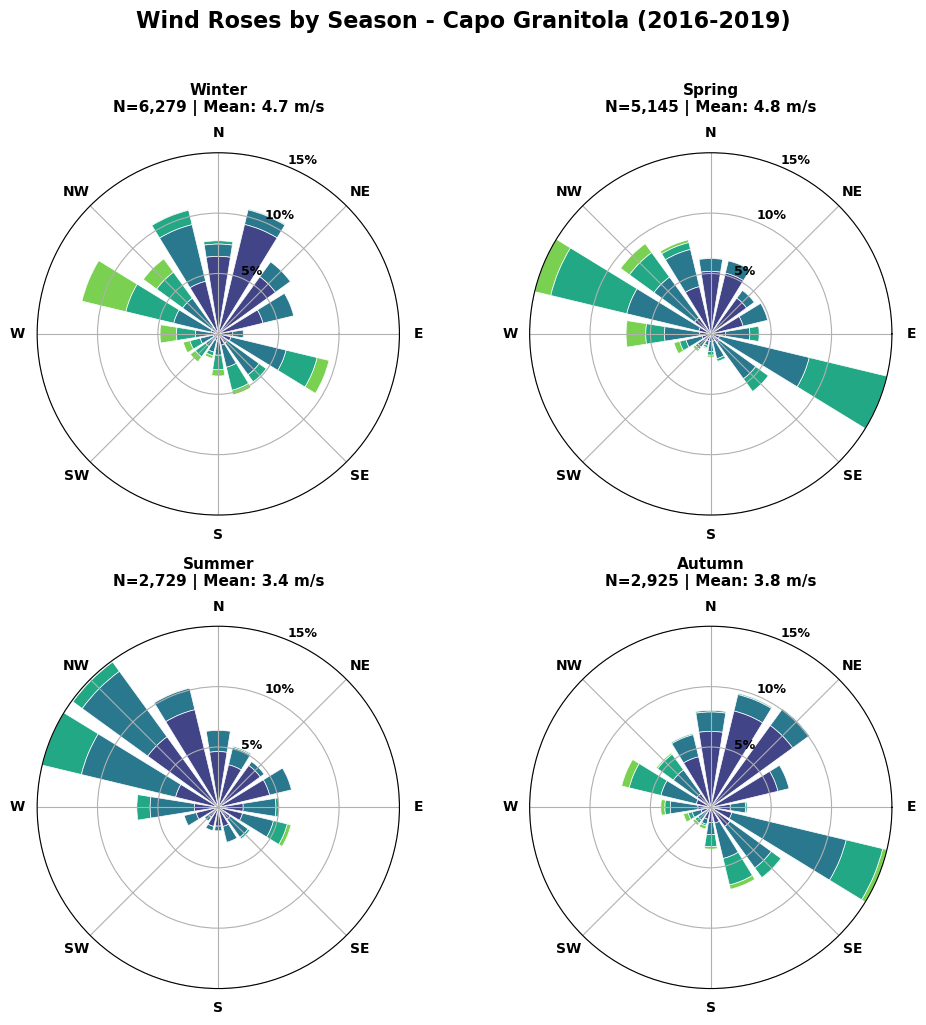


SEASONAL WIND STATISTICS

 data of Winterlength: 6279

 data of Springlength: 5145

 data of Summerlength: 2729

 data of Autumnlength: 2925

Seasonal Statistics Summary:
Season    N  Mean Speed (m/s)  Std Speed (m/s)  Max Speed (m/s)  Min Speed (m/s)  Mean Direction (°) Prevailing Direction
Winter 6279              4.69             2.80            15.90             0.60              182.68                    W
Spring 5145              4.82             2.65            16.80             0.60              194.54                    W
Summer 2729              3.42             1.88            10.30             0.60              215.58                    W
Autumn 2925              3.84             2.28            15.60             0.60              156.79                    E

✓ Seasonal statistics saved to 'seasonal_wind_statistics.csv'

MONTHLY WIND ANALYSIS

Monthly Statistics:
      wind_speed                        wind_direction        
           count  mean   std   max  min         

In [34]:


# Assuming meteo_CG_16_19_filt has columns: ['wind_speed', 'wind_direction', 'month', 'season']

# Get overall statistics for consistent binning
overall_max_speed = meteo_CG_16_19_filt['wind_speed'].max()
speed_bins = [0.5, 1, 3, 6, 9, overall_max_speed]
bin_labels = [
    '0.5-1',     
    '1-3',       
    '3-6',       
    '6-9',       
    f'9-{overall_max_speed:.1f}'      
]

# Define seasons in order
seasons_order = ['Winter', 'Spring', 'Summer', 'Autumn']

# Check which seasons actually have data
seasons_with_data = []
for season in seasons_order:
    season_data = meteo_CG_16_19_filt[meteo_CG_16_19_filt['season'] == season]
    if len(season_data) > 0:
        seasons_with_data.append(season)
        print(f"✓ {season}: {len(season_data)} data points")
    else:
        print(f"✗ {season}: No data")

# Create individual plots for each season with data
print("\n" + "="*60)
print("Creating individual wind rose plots for each season...")
print("="*60)

for season in seasons_with_data:
    # Filter data for this season
    season_data = meteo_CG_16_19_filt[meteo_CG_16_19_filt['season'] == season]
    
    ws_season = season_data['wind_speed'].values
    wd_season = season_data['wind_direction'].values
    
    # Calculate statistics
    total_points = len(ws_season)
    mean_speed = np.mean(ws_season)
    max_speed = np.max(ws_season)
    
    # Create individual figure
    fig_ind = plt.figure(figsize=(12, 10))
    ax_ind = WindroseAxes.from_ax(fig=fig_ind)
    
    # Plot
    bars = ax_ind.bar(wd_season, ws_season, normed=True, opening=0.8, edgecolor='white',
                      linewidth=0.5, bins=speed_bins, cmap=plt.cm.viridis)
    
    # Customize
    ax_ind.set_yticks([5, 10, 15])
    ax_ind.set_yticklabels(['5%', '10%', '15%'], fontsize=10, fontweight='bold')
    ax_ind.set_ylim(0, 15)
    ax_ind.set_xticklabels(['E', 'NE', 'N', 'NW', 'W', 'SW', 'S', 'SE'],
                           fontsize=11, fontweight='bold')
    
    # Legend
    legend = ax_ind.legend(title='Wind Speed [m/s]', loc='center left',
                           bbox_to_anchor=(1.1, 0.5), labels=bin_labels)
    
    # Title with statistics
    plt.title(f'Wind Rose - {season} | Capo Granitola (2016-2019)\n'
              f'Total measurements: {total_points:,} | '
              f'Mean speed: {mean_speed:.1f} m/s | '
              f'Max speed: {max_speed:.1f} m/s',
              fontsize=14, fontweight='bold', pad=20)
    
    plt.tight_layout()
    
    # Save individual plot
    filename = f'wind_rose_{season.lower()}.png'
    fig_ind.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
    print(f"✓ {season} wind rose saved as '{filename}'")
    
    plt.show()

# Now create a combined plot ONLY if we have data for multiple seasons
if len(seasons_with_data) > 1:
    print("\n" + "="*60)
    print(f"Creating combined plot for {len(seasons_with_data)} seasons...")
    print("="*60)
    
    # Determine grid layout
    n_seasons = len(seasons_with_data)
    if n_seasons <= 2:
        n_rows, n_cols = 1, n_seasons
    elif n_seasons <= 4:
        n_rows, n_cols = 2, 2
    else:
        n_rows, n_cols = (n_seasons + 1) // 2, 2
    
    # Create figure with subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows), 
                             subplot_kw=dict(projection='windrose'))
    fig.suptitle('Wind Roses by Season - Capo Granitola (2016-2019)', 
                 fontsize=16, fontweight='bold', y=1.02)
    
    # Flatten axes if needed
    if n_seasons > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
    
    # Hide unused axes
    for i in range(n_seasons, len(axes)):
        axes[i].set_visible(False)
    
    # Plot wind rose for each season with data
    handles_list = []
    labels_list = []
    
    for idx, season in enumerate(seasons_with_data):
        if idx >= len(axes):
            break
            
        # Filter data for this season
        season_data = meteo_CG_16_19_filt[meteo_CG_16_19_filt['season'] == season]
        
        ws_season = season_data['wind_speed'].values
        wd_season = season_data['wind_direction'].values
        
        # Calculate season statistics
        total_points = len(ws_season)
        mean_speed = np.mean(ws_season)
        max_speed = np.max(ws_season)
        
        # Create wind rose for this season
        ax = axes[idx]
        bars = ax.bar(wd_season, ws_season, normed=True, opening=0.8, edgecolor='white',
                      linewidth=0.5, bins=speed_bins, cmap=plt.cm.viridis)
        
        # Customize this subplot
        ax.set_title(f'{season}\nN={total_points:,} | Mean: {mean_speed:.1f} m/s',
                     fontsize=11, fontweight='bold', pad=10)
        
        # Set radial grid
        ax.set_yticks([5, 10, 15])
        ax.set_yticklabels(['5%', '10%', '15%'], fontsize=9, fontweight='bold')
        ax.set_ylim(0, 15)
        
        # Set directional labels
        ax.set_xticklabels(['E', 'NE', 'N', 'NW', 'W', 'SW', 'S', 'SE'],
                           fontsize=10, fontweight='bold')
        
        # Store handles and labels for legend
        if idx == 0:  # Only need one set for legend
            handles, labels = ax.get_legend_handles_labels()
            handles_list.extend(handles)
            labels_list.extend(labels)
    
    # Adjust layout
    plt.tight_layout()
    
    # Add a global legend if we have handles
    if handles_list and labels_list:
        fig.legend(handles_list, bin_labels, title='Wind Speed [m/s]',
                   loc='center right', bbox_to_anchor=(1.05, 0.5),
                   fontsize=10, title_fontsize=11)
    
    # Save the combined seasonal plot
    output_filename_combined = 'wind_rose_seasons_combined.png'
    fig.savefig(output_filename_combined, dpi=300, bbox_inches='tight', 
                facecolor='white', edgecolor='none')
    print(f"✓ Combined seasonal plot saved as '{output_filename_combined}'")
    
    plt.show()

# COMPARISON STATISTICS TABLE
print("\n" + "="*60)
print("SEASONAL WIND STATISTICS")
print("="*60)

seasonal_stats = []
for season in seasons_order:
    season_data = meteo_CG_16_19_filt[meteo_CG_16_19_filt['season'] == season]
    print(f"\n data of {season}length: {len(season_data)}")  
    
    if len(season_data) > 0:
        # Calculate prevailing direction
        directions = season_data['wind_direction'].values
        
        # Function to get prevailing direction
        def get_prevailing_direction(directions):
            if len(directions) == 0:
                return 'N/A'
            # Bin directions into 8 compass points
            bins = np.linspace(0, 360, 9)  # 0, 45, 90, 135, 180, 225, 270, 315, 360
            labels = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']
            # Get histogram
            hist, _ = np.histogram(directions % 360, bins=bins)
            # Find max
            max_idx = np.argmax(hist)
            return labels[max_idx]
        
        stats = {
            'Season': season,
            'N': len(season_data),
            'Mean Speed (m/s)': round (season_data['wind_speed'].mean(),2),
            'Std Speed (m/s)': round (season_data['wind_speed'].std(), 3),
            'Max Speed (m/s)': round (season_data['wind_speed'].max(), 2),
            'Min Speed (m/s)': round (season_data['wind_speed'].min(),2),
            'Mean Direction (°)': season_data['wind_direction'].mean(),
            'Prevailing Direction': get_prevailing_direction(directions)
        }
        seasonal_stats.append(stats)

# Convert to DataFrame
if seasonal_stats:
    stats_df = pd.DataFrame(seasonal_stats)
    print("\nSeasonal Statistics Summary:")
    print(stats_df.to_string(index=False, float_format='%.2f'))
    
    # Save statistics to CSV
    stats_df.to_csv('seasonal_wind_statistics.csv', index=False)
    print(f"\n✓ Seasonal statistics saved to 'seasonal_wind_statistics.csv'")
else:
    print("No seasonal statistics to display.")

# MONTHLY ANALYSIS
print("\n" + "="*60)
print("MONTHLY WIND ANALYSIS")
print("="*60)

# Create monthly wind roses if you have month data
if 'month' in meteo_CG_16_19_filt.columns:
    # Group by month
    monthly_stats = meteo_CG_16_19_filt.groupby('month').agg({
        'wind_speed': ['count', 'mean', 'std', 'max', 'min'],
        'wind_direction': ['mean', 'std']
    }).round(2)
    
    print("\nMonthly Statistics:")
    print(monthly_stats)
    
    # Save monthly stats
    monthly_stats.to_csv('monthly_wind_statistics.csv')
    print(f"\n✓ Monthly statistics saved to 'monthly_wind_statistics.csv'")

print("\n" + "="*60)
print("ANALYSIS COMPLETE!")
print("="*60)
print(f"Created plots for {len(seasons_with_data)} seasons: {', '.join(seasons_with_data)}")
if len(seasons_with_data) > 1:
    print("✓ Combined seasonal plot created")
print("✓ Individual seasonal plots created")
print("✓ Statistical summaries saved to CSV files")